# A Diffusion Model from Scratch in Pytorch


### Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch import optim
import os
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

### Dataset preprocessing

100%|██████████| 344862509/344862509 [00:03<00:00, 98492661.32it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 1361047.58it/s]


100%|██████████| 14989/14989 [00:00<00:00, 36214529.18it/s]


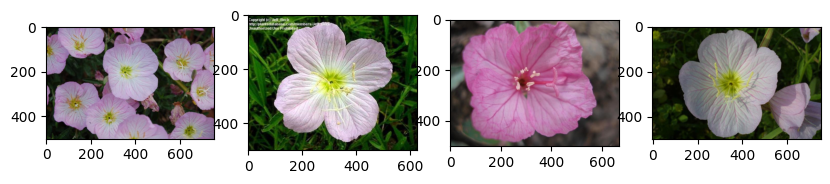

In [2]:
def show_images(datset, num_samples=4, cols=4):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.Flowers102(root=".", download=True)
show_images(data)

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 8

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### Forward Process

In [4]:
def prepare_noise_schedule(noise_steps, beta_start=0.0001, beta_end=0.02):
        return torch.linspace(beta_start, beta_end, noise_steps)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
T = 300
beta = prepare_noise_schedule(noise_steps=T).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, axis=0)

In [6]:
def forward_diffusion_sample(x, t):
    noise = torch.randn_like(x)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]

    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

<ipython-input-7-124d7bafbdef>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


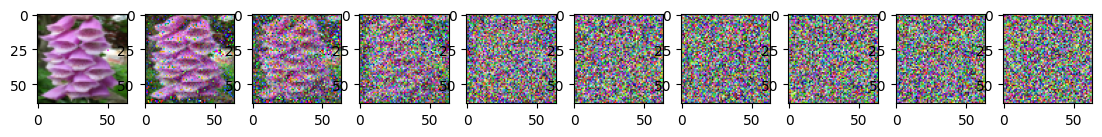

In [7]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image.to(device), t.to(device))
    show_tensor_image(img.cpu())

### Model Architecture

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [10]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [11]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [12]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [13]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  23332739


### Sampling

In [14]:
def sample_timesteps(n):
    return torch.randint(low=1, high=T, size=(n,))

def sample(model, n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(device)
        for i in tqdm(reversed(range(1, T)), position=0):
            t = (torch.ones(n) * i).long().to(device)
            predicted_noise = model(x, t)
            alpha_t = alpha[t][:, None, None, None]
            alpha_hat_t = alpha_hat[t][:, None, None, None]
            beta_t = beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / (torch.sqrt(1 - alpha_hat_t))) * predicted_noise) + torch.sqrt(beta_t) * noise
    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

### Training

In [15]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [16]:
def train(dataloader, args):
    device = args.device
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = sample_timesteps(images.shape[0]).to(device)
            x_t, noise = forward_diffusion_sample(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        sampled_images = sample(model, n=images.shape[0])
        plot_images(sampled_images)
        save_images(sampled_images, os.path.join("results", f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", f"ckpt.pt"))

In [17]:
os.makedirs(os.path.join("models"), exist_ok=True)
os.makedirs(os.path.join("results"), exist_ok=True)

100%|██████████| 896/896 [04:53<00:00,  3.05it/s, MSE=0.122]
299it [00:30,  9.81it/s]


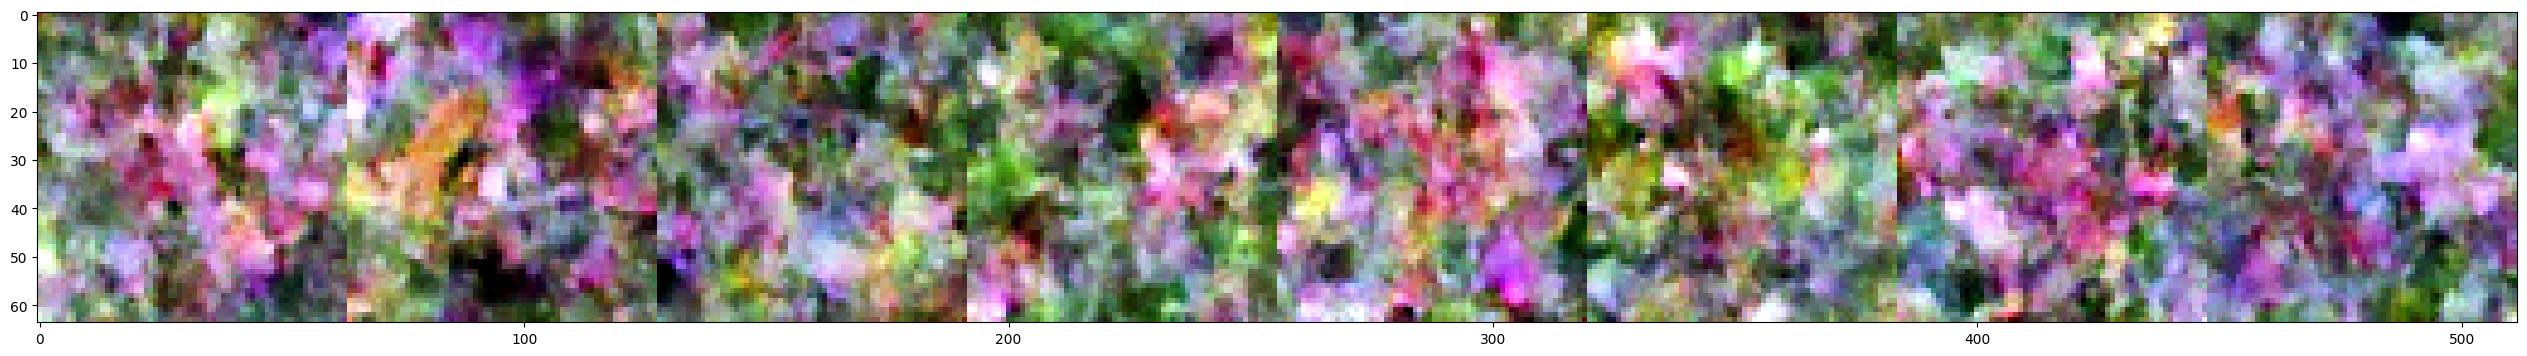

100%|██████████| 896/896 [04:48<00:00,  3.10it/s, MSE=0.0586]
299it [00:30,  9.80it/s]


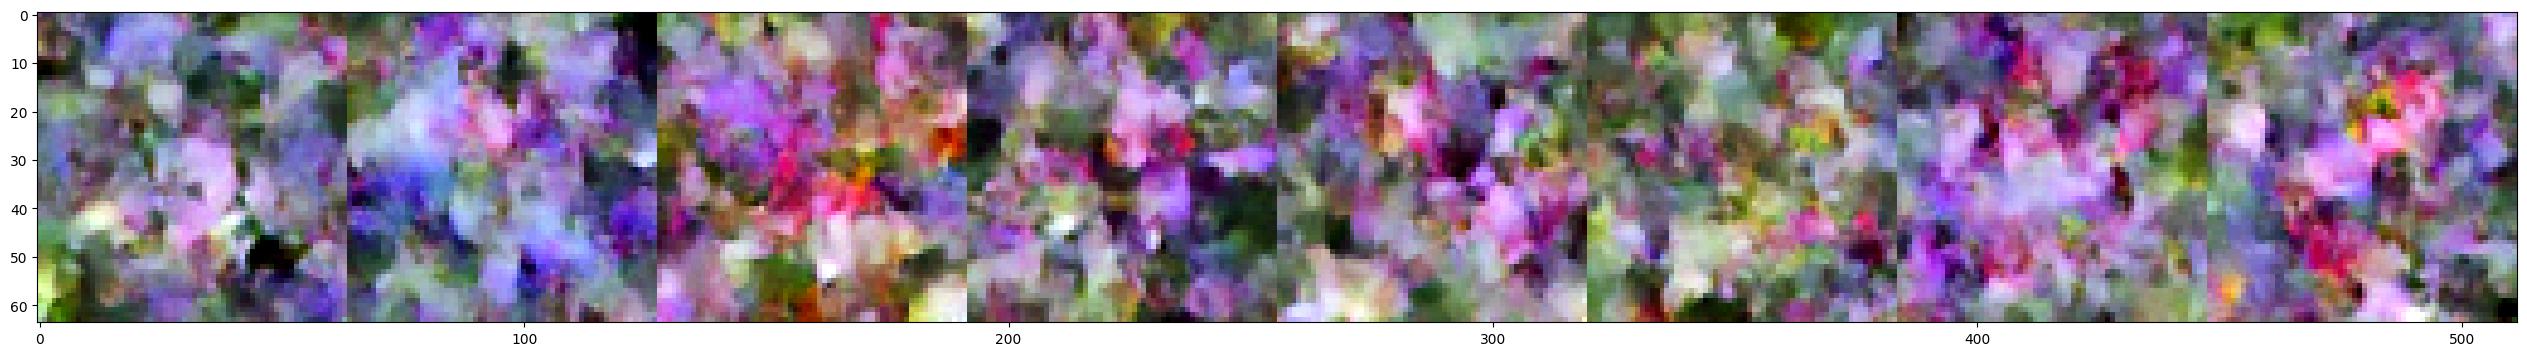

100%|██████████| 896/896 [04:49<00:00,  3.09it/s, MSE=0.0267]
299it [00:30,  9.81it/s]


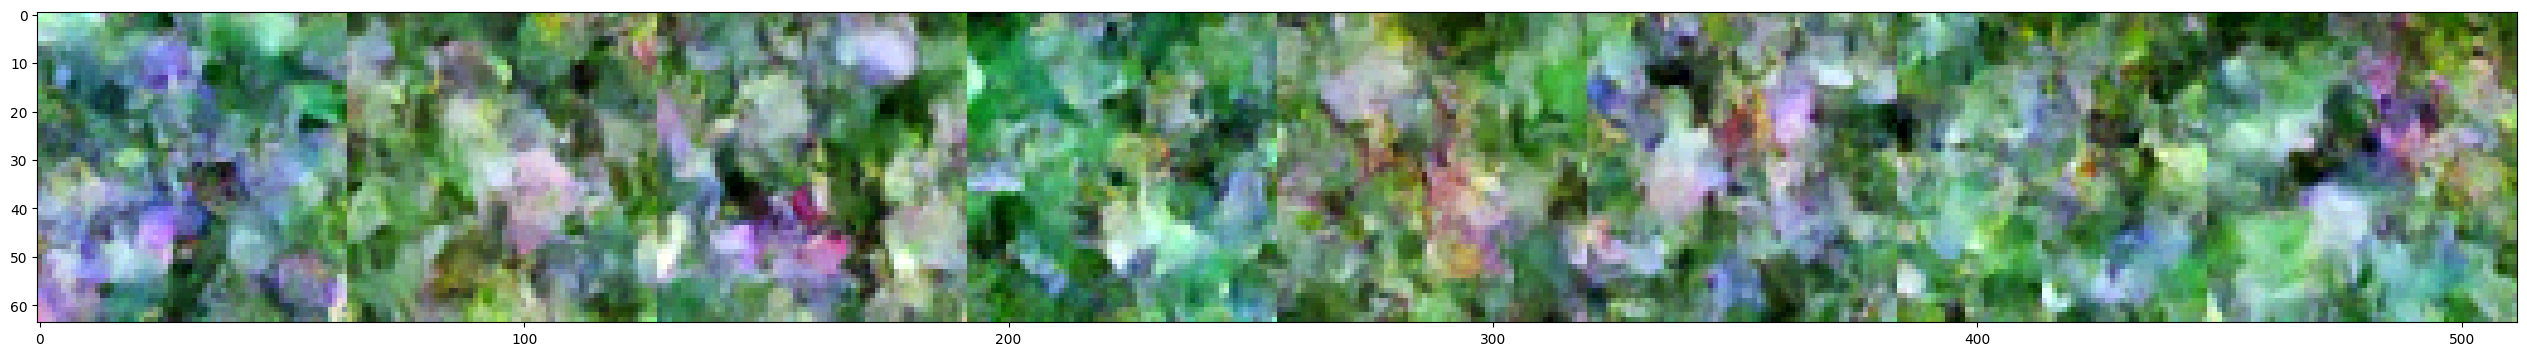

100%|██████████| 896/896 [04:53<00:00,  3.05it/s, MSE=0.0725]
299it [00:30,  9.80it/s]


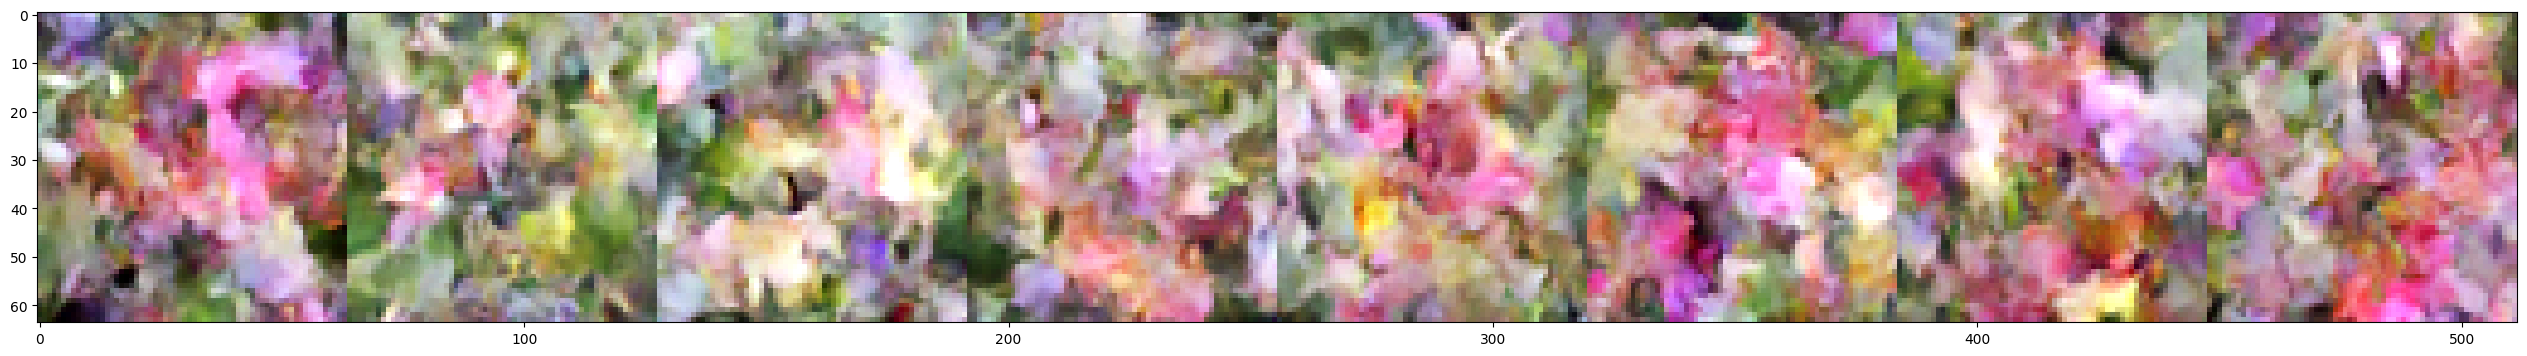

100%|██████████| 896/896 [04:53<00:00,  3.05it/s, MSE=0.0343]
299it [00:30,  9.81it/s]


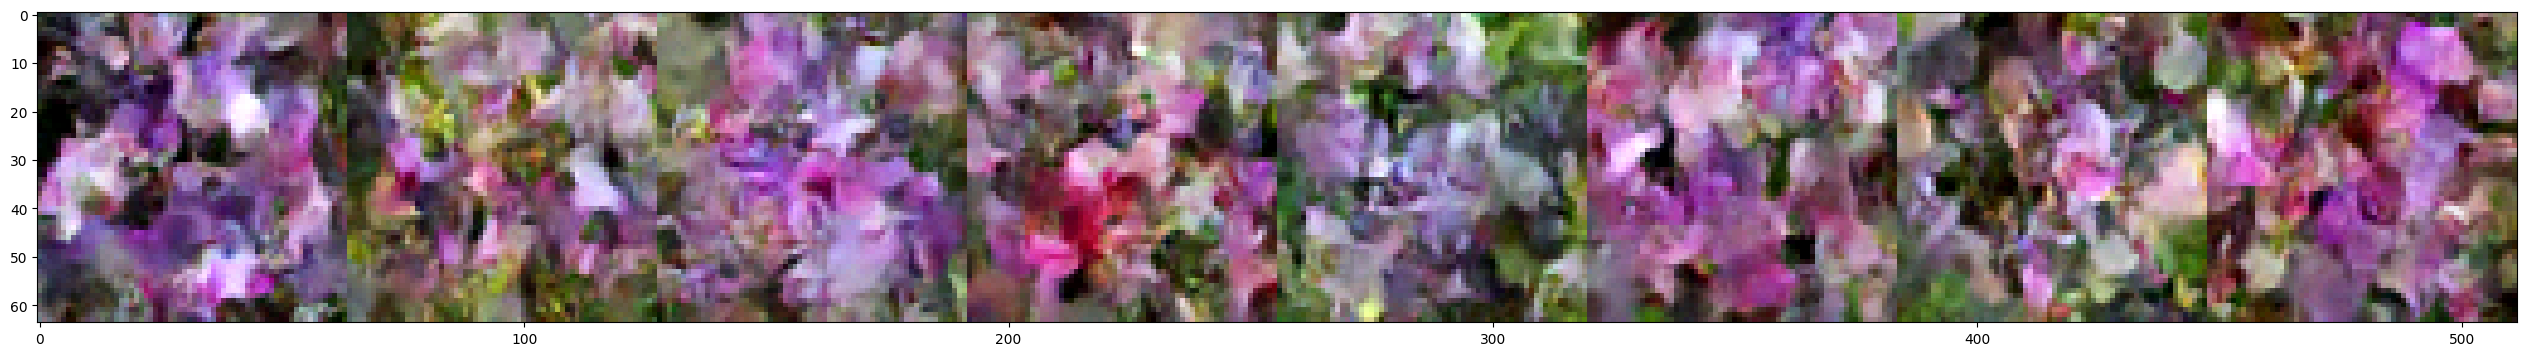

100%|██████████| 896/896 [04:54<00:00,  3.05it/s, MSE=0.0292]
299it [00:30,  9.80it/s]


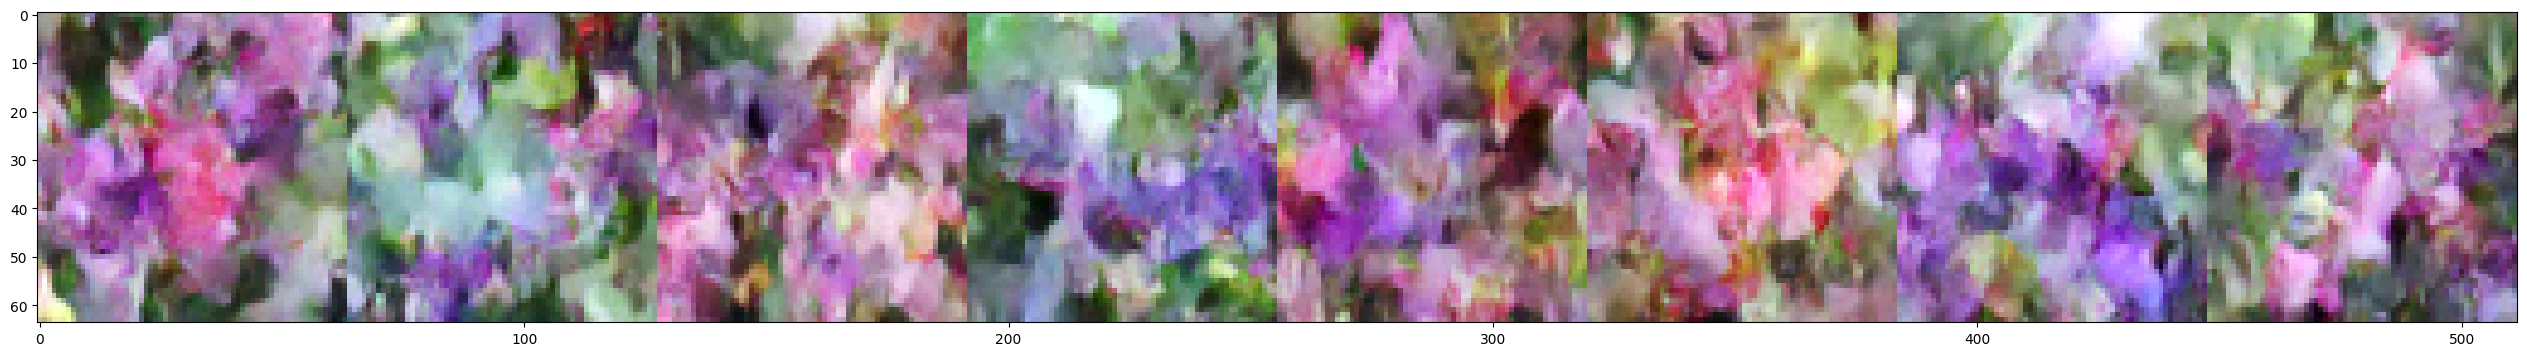

100%|██████████| 896/896 [04:55<00:00,  3.04it/s, MSE=0.031]
299it [00:30,  9.79it/s]


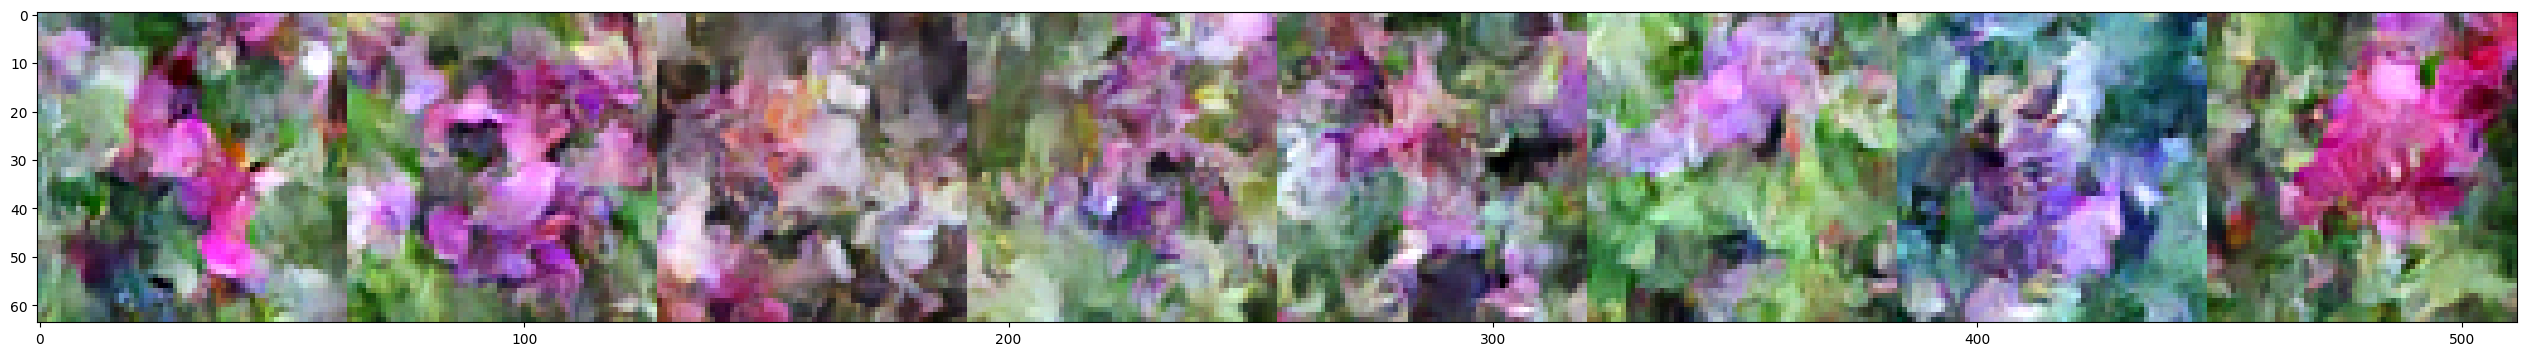

100%|██████████| 896/896 [04:57<00:00,  3.01it/s, MSE=0.0778]
299it [00:31,  9.64it/s]


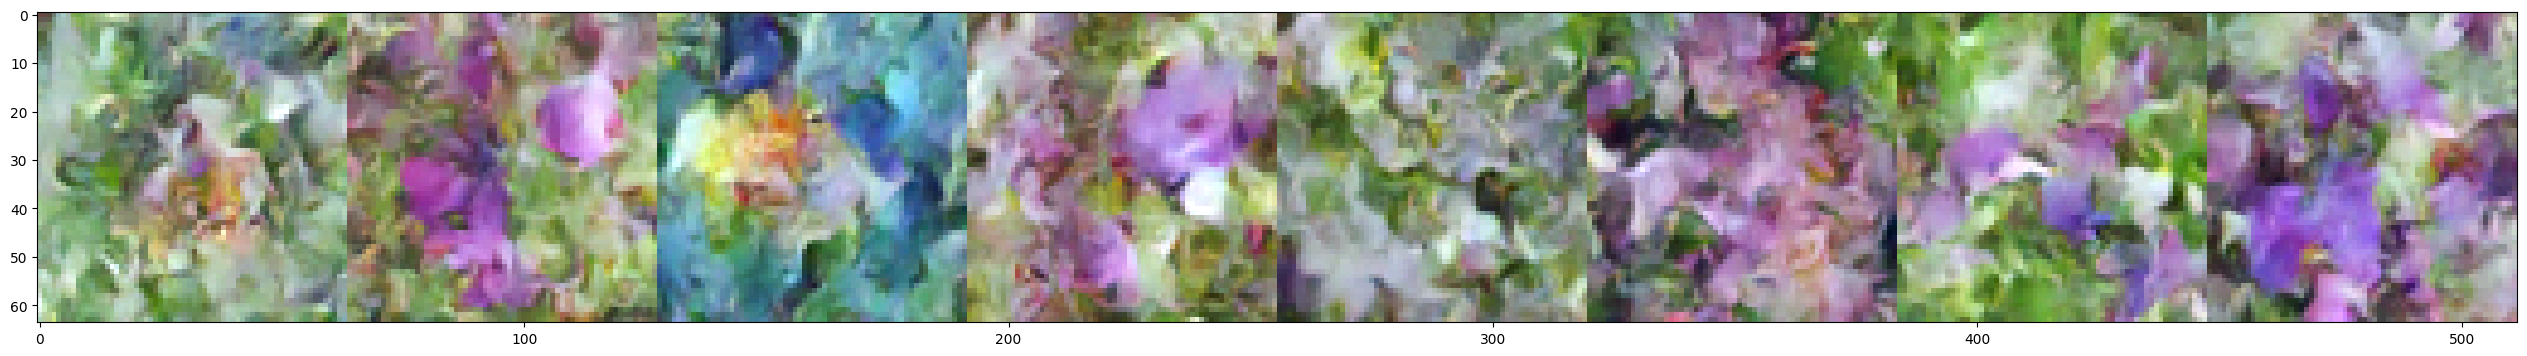

100%|██████████| 896/896 [04:57<00:00,  3.01it/s, MSE=0.103]
299it [00:30,  9.79it/s]


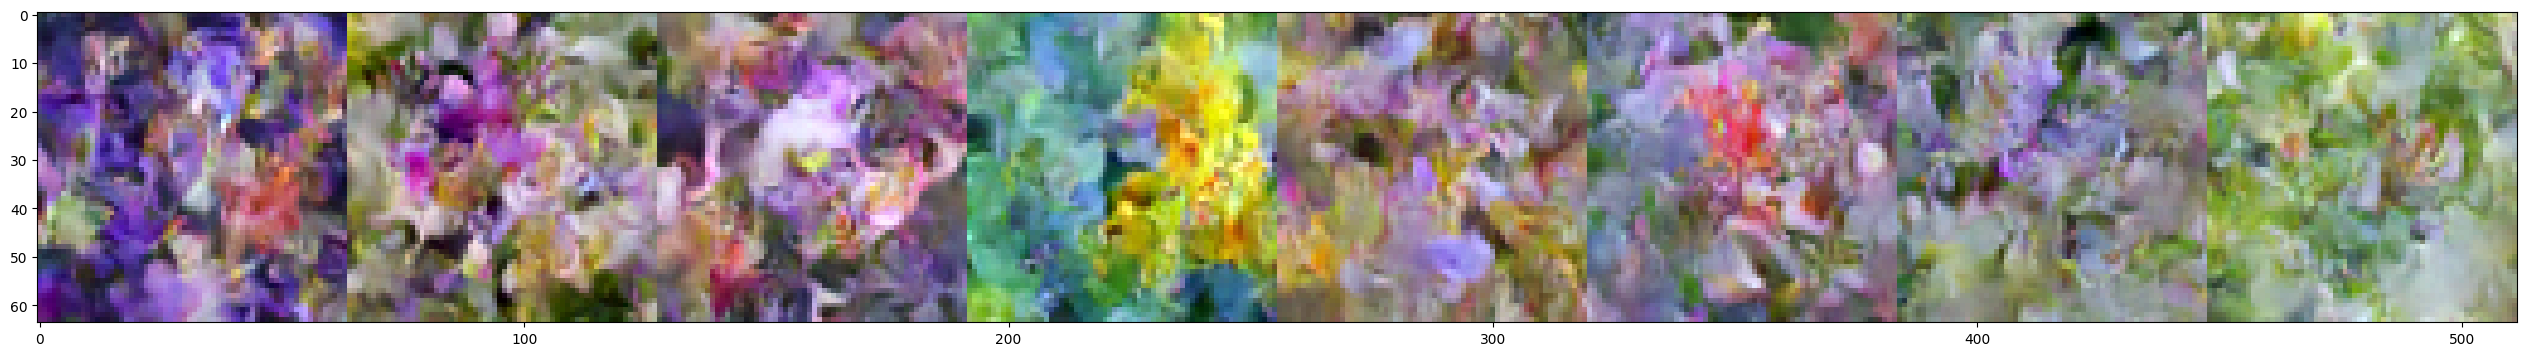

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0704]
299it [00:30,  9.81it/s]


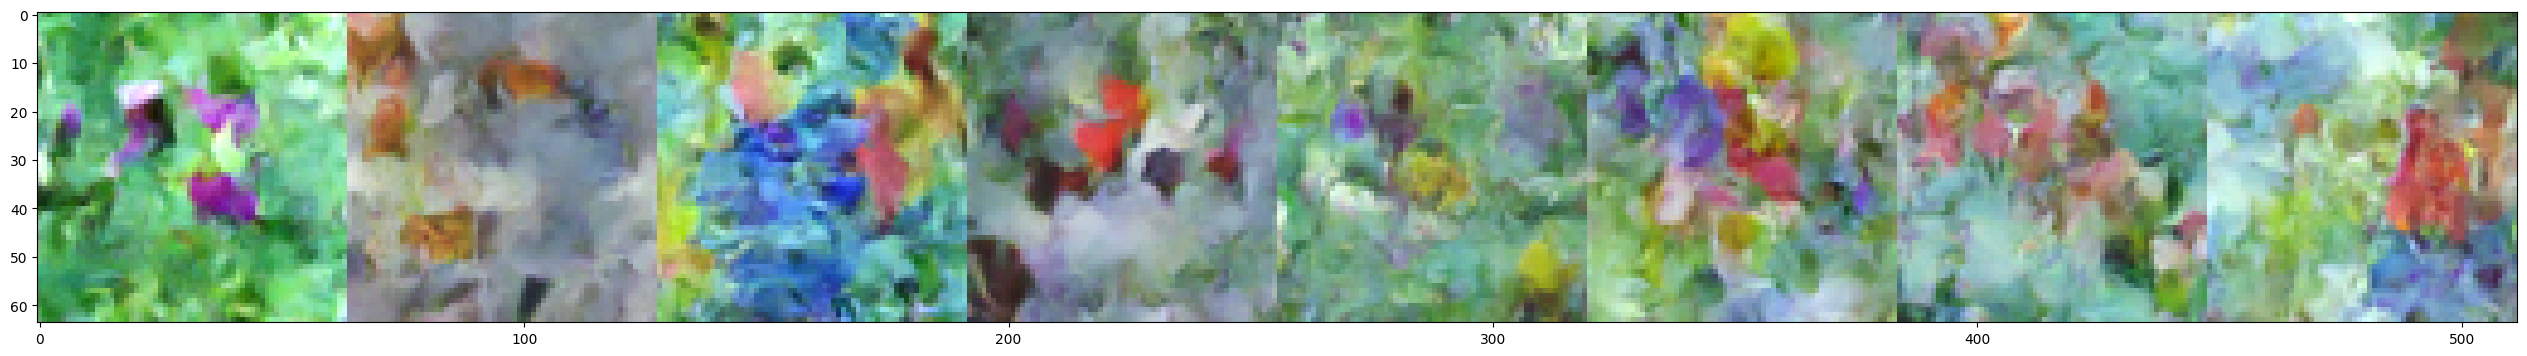

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0245]
299it [00:30,  9.80it/s]


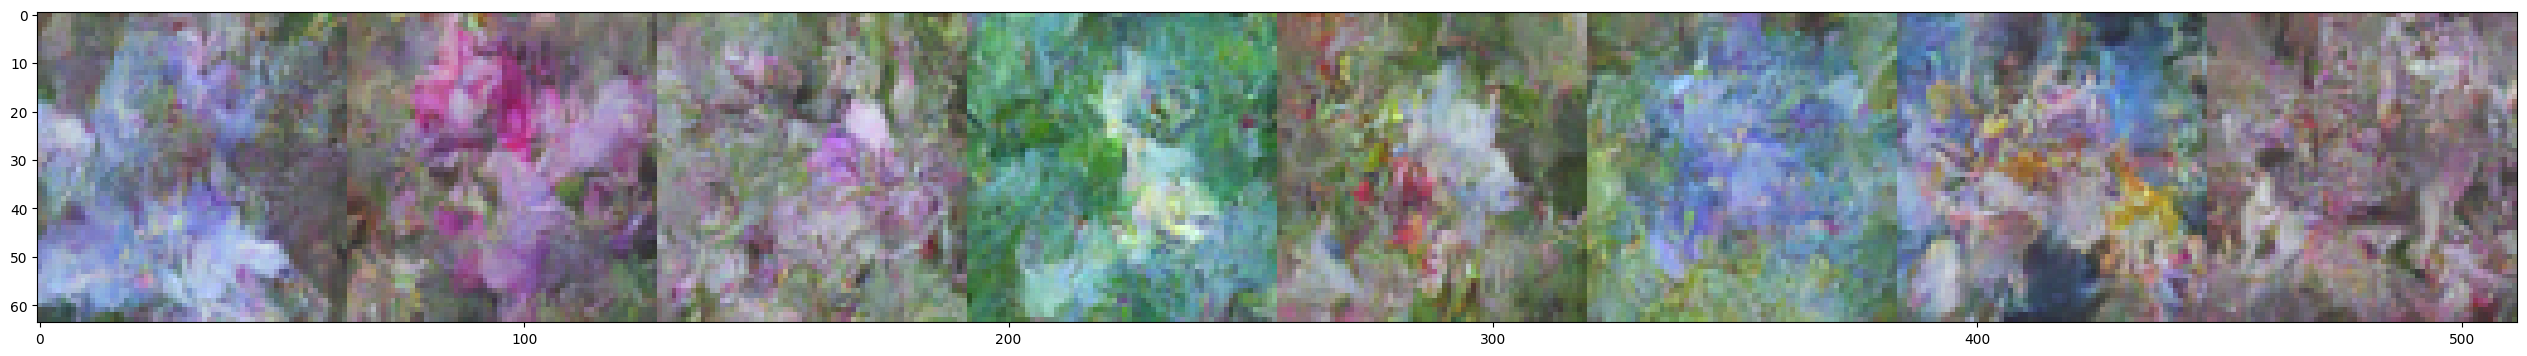

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0329]
299it [00:30,  9.79it/s]


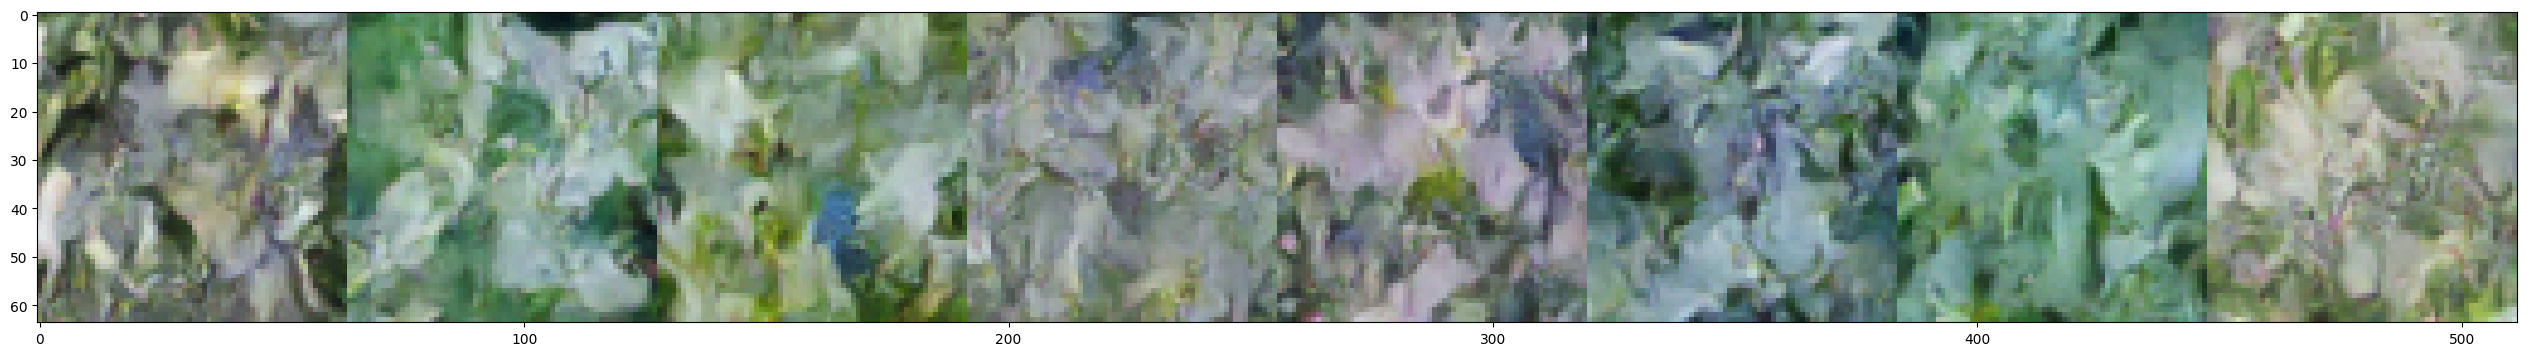

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0886]
299it [00:30,  9.79it/s]


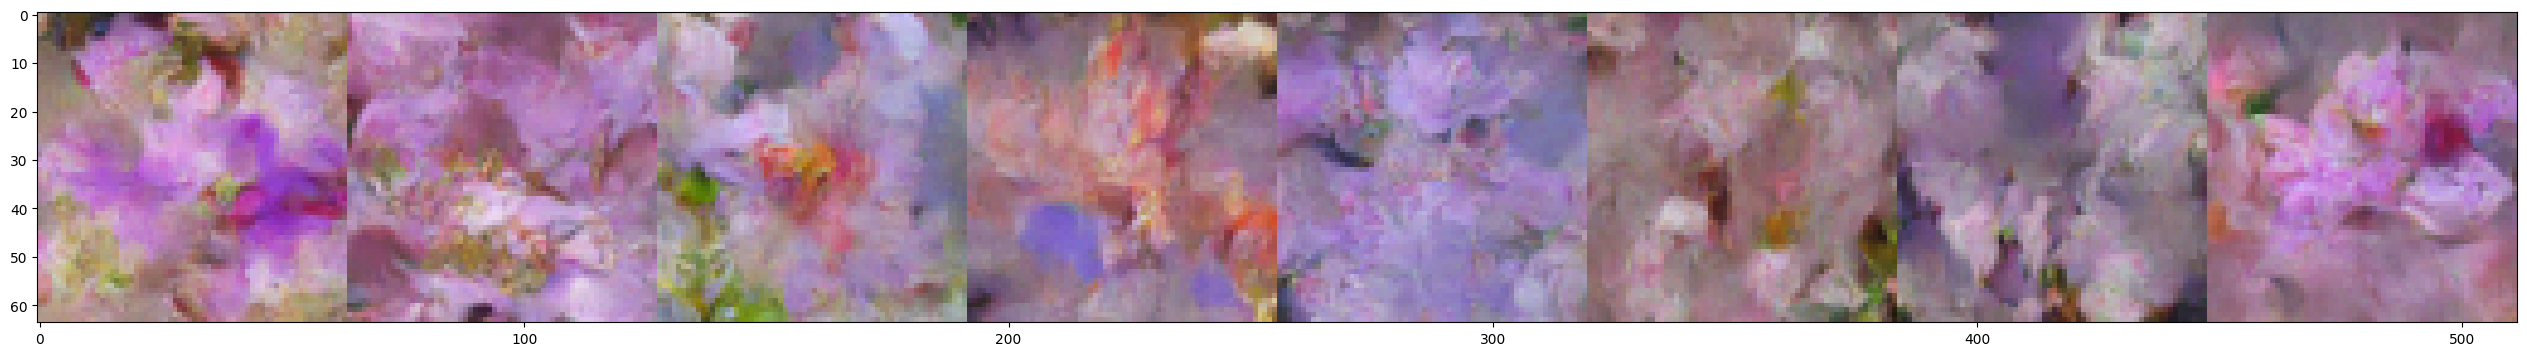

100%|██████████| 896/896 [04:59<00:00,  3.00it/s, MSE=0.0609]
299it [00:30,  9.77it/s]


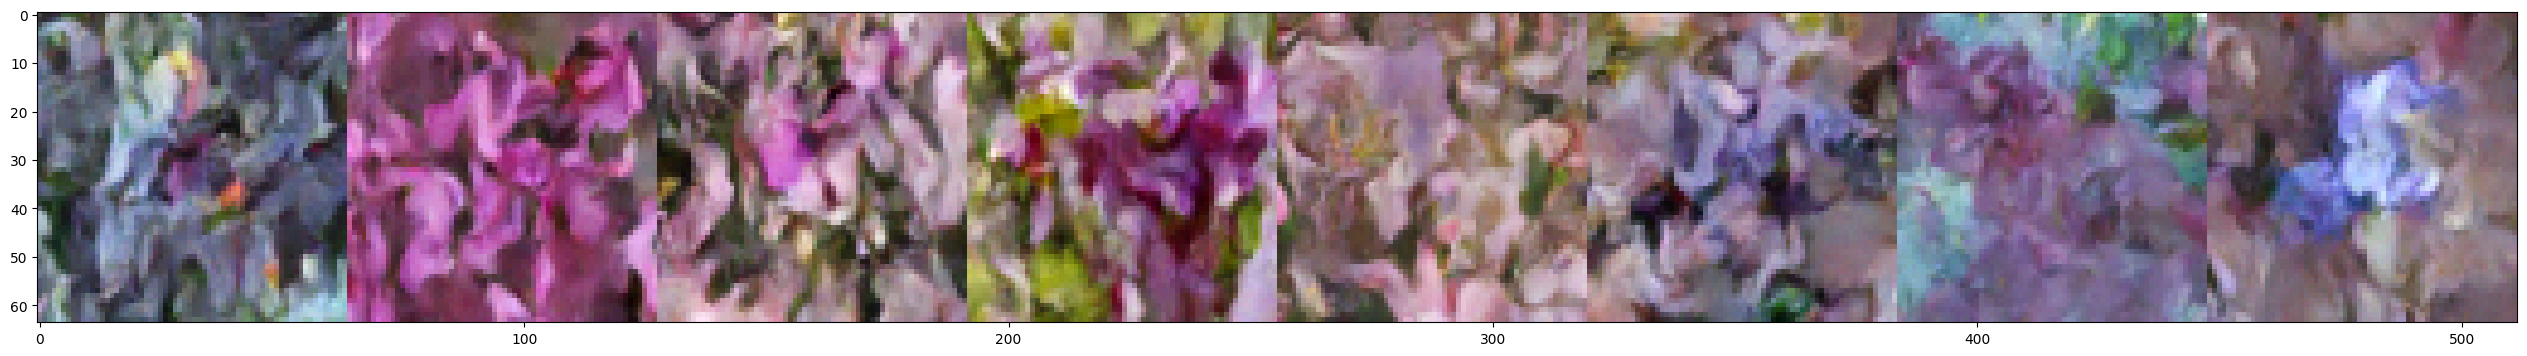

100%|██████████| 896/896 [05:01<00:00,  2.98it/s, MSE=0.0381]
299it [00:30,  9.78it/s]


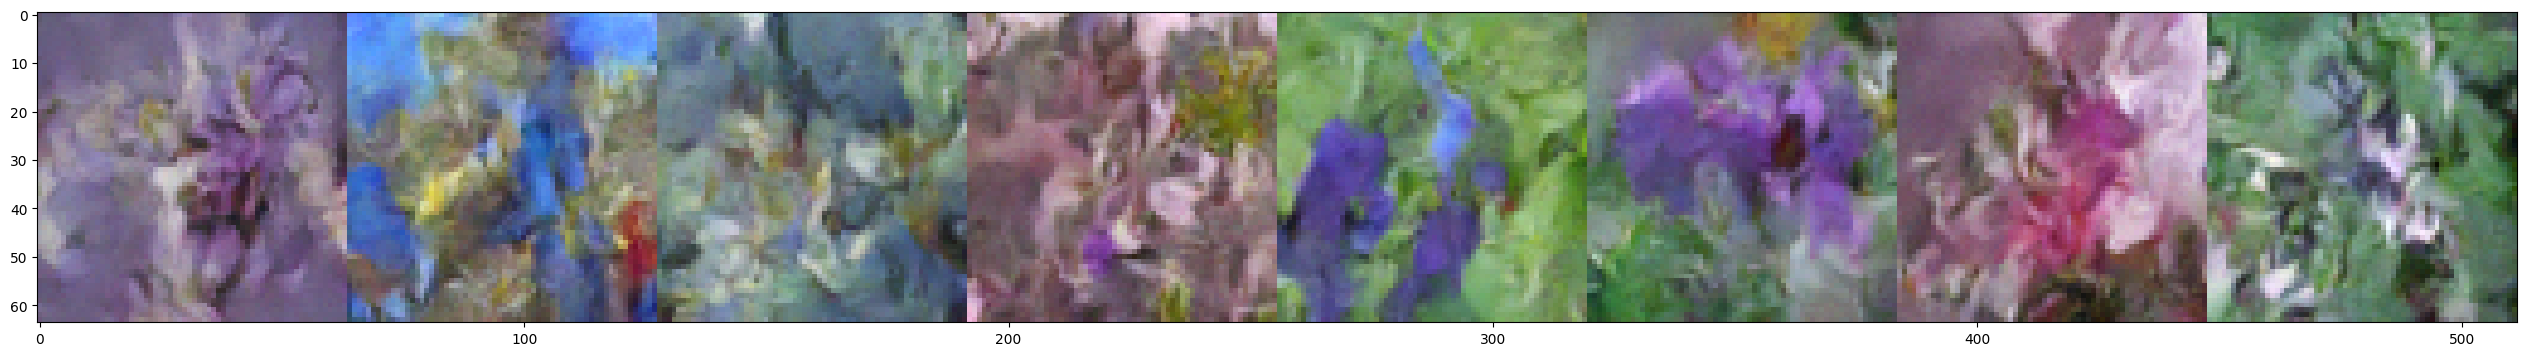

100%|██████████| 896/896 [05:02<00:00,  2.96it/s, MSE=0.0299]
299it [00:30,  9.78it/s]


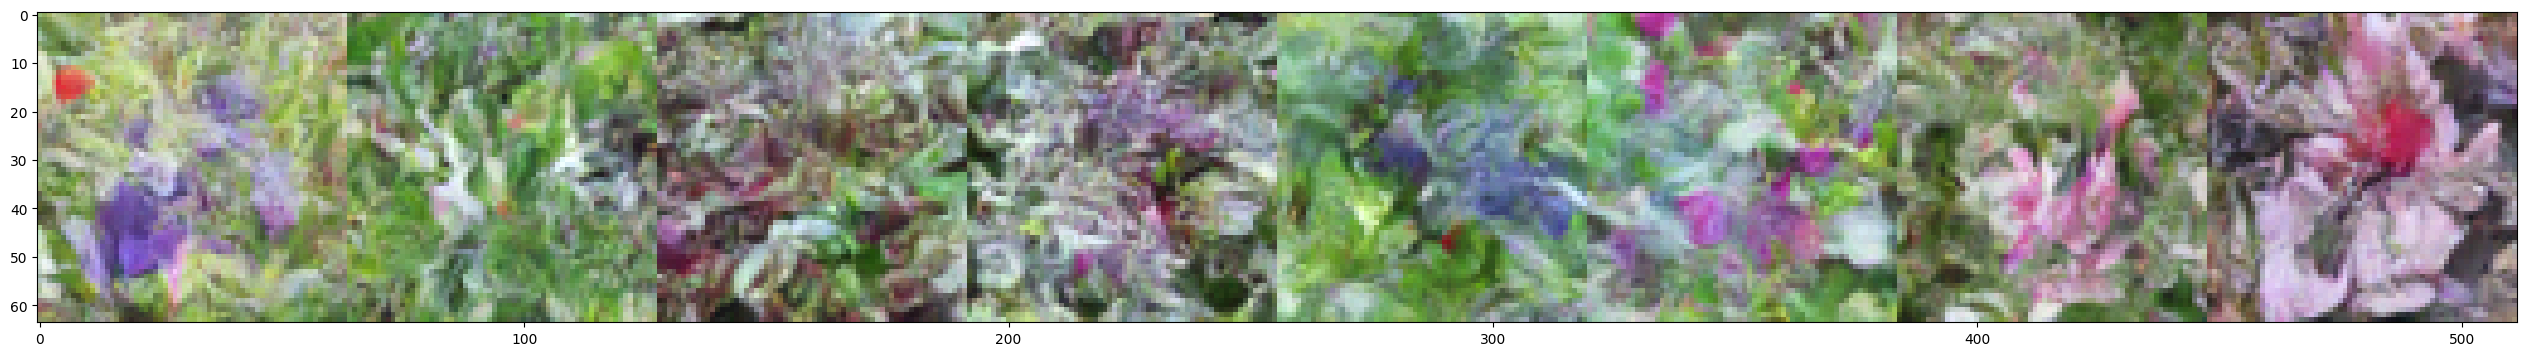

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0546]
299it [00:30,  9.79it/s]


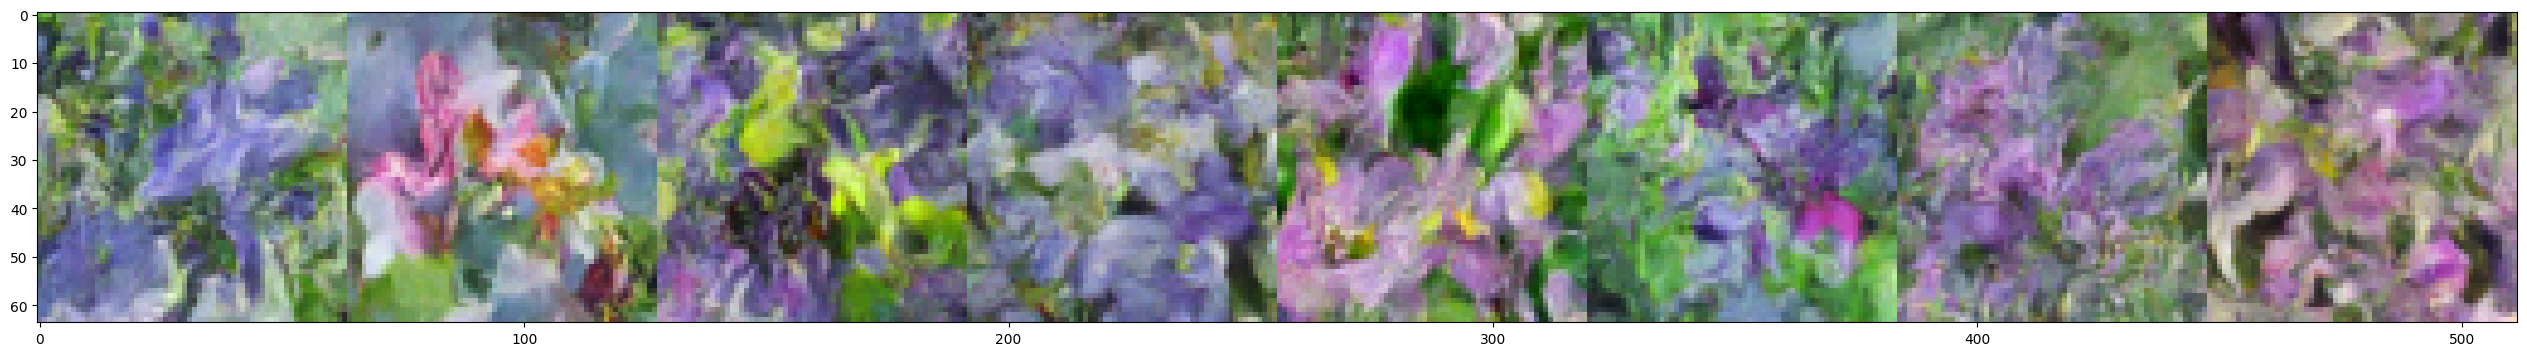

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0313]
299it [00:30,  9.78it/s]


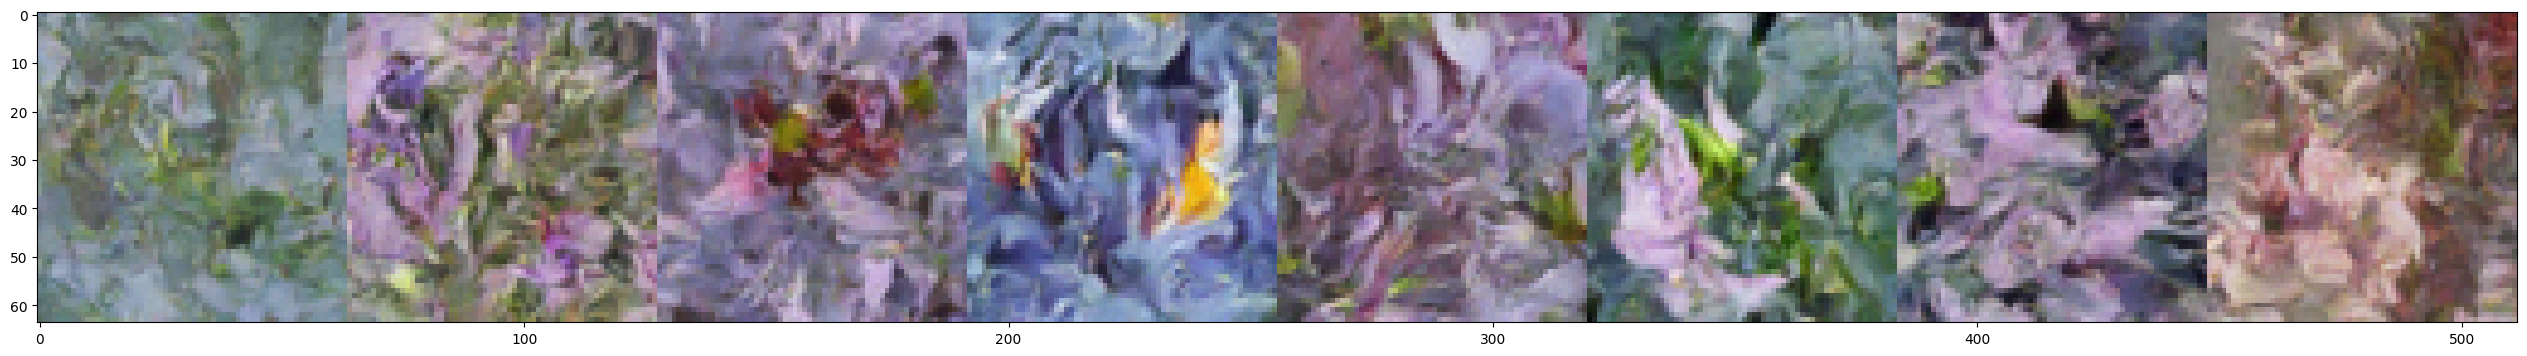

100%|██████████| 896/896 [04:59<00:00,  2.99it/s, MSE=0.0407]
299it [00:30,  9.79it/s]


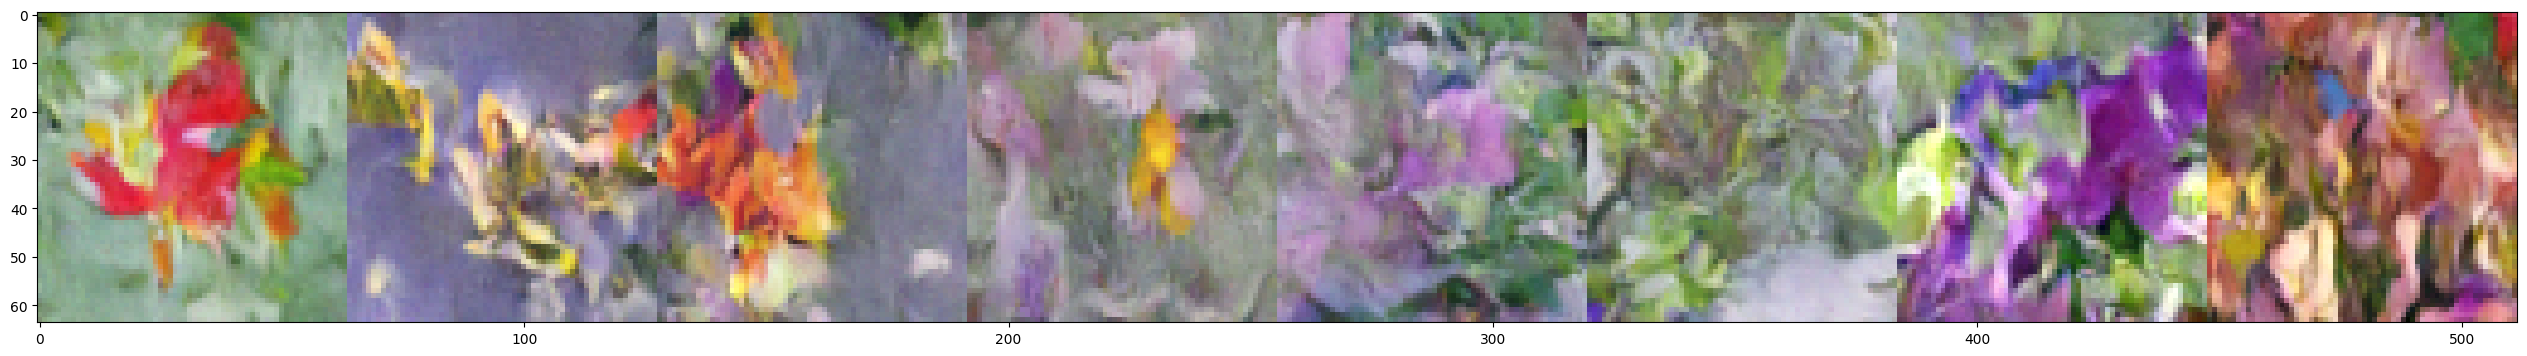

100%|██████████| 896/896 [04:59<00:00,  2.99it/s, MSE=0.0518]
299it [00:30,  9.87it/s]


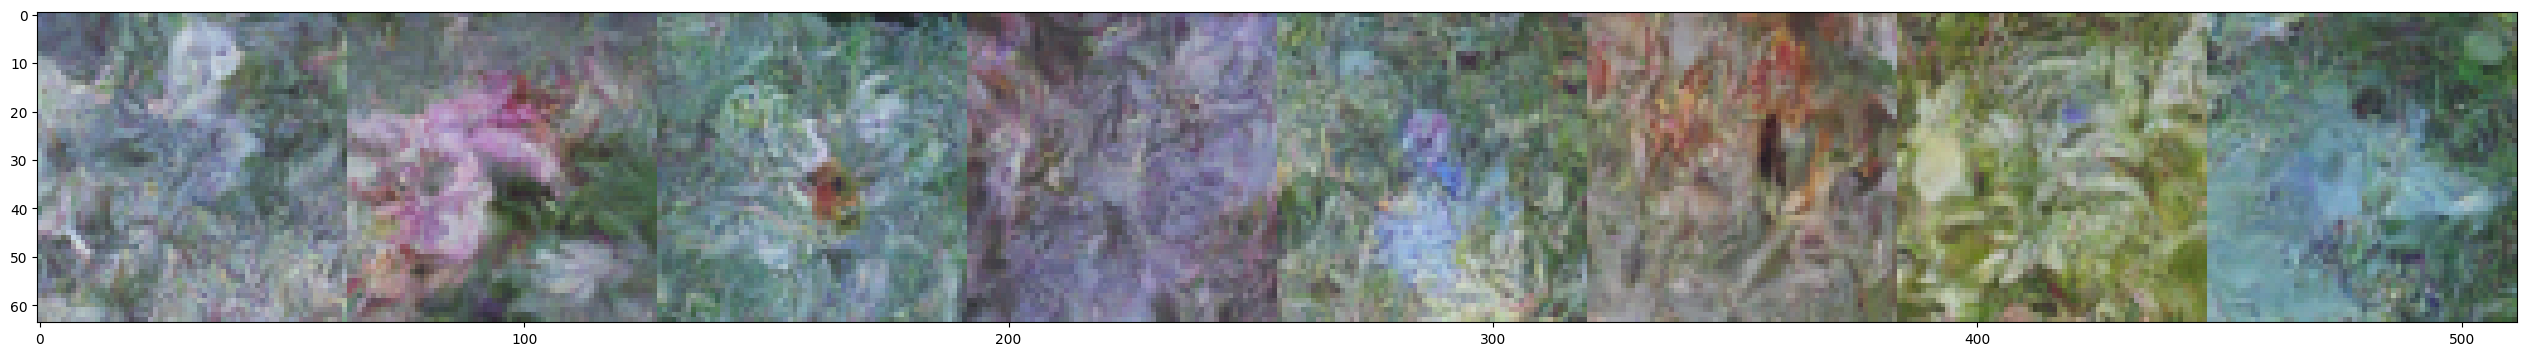

100%|██████████| 896/896 [04:58<00:00,  3.00it/s, MSE=0.0318]
299it [00:30,  9.80it/s]


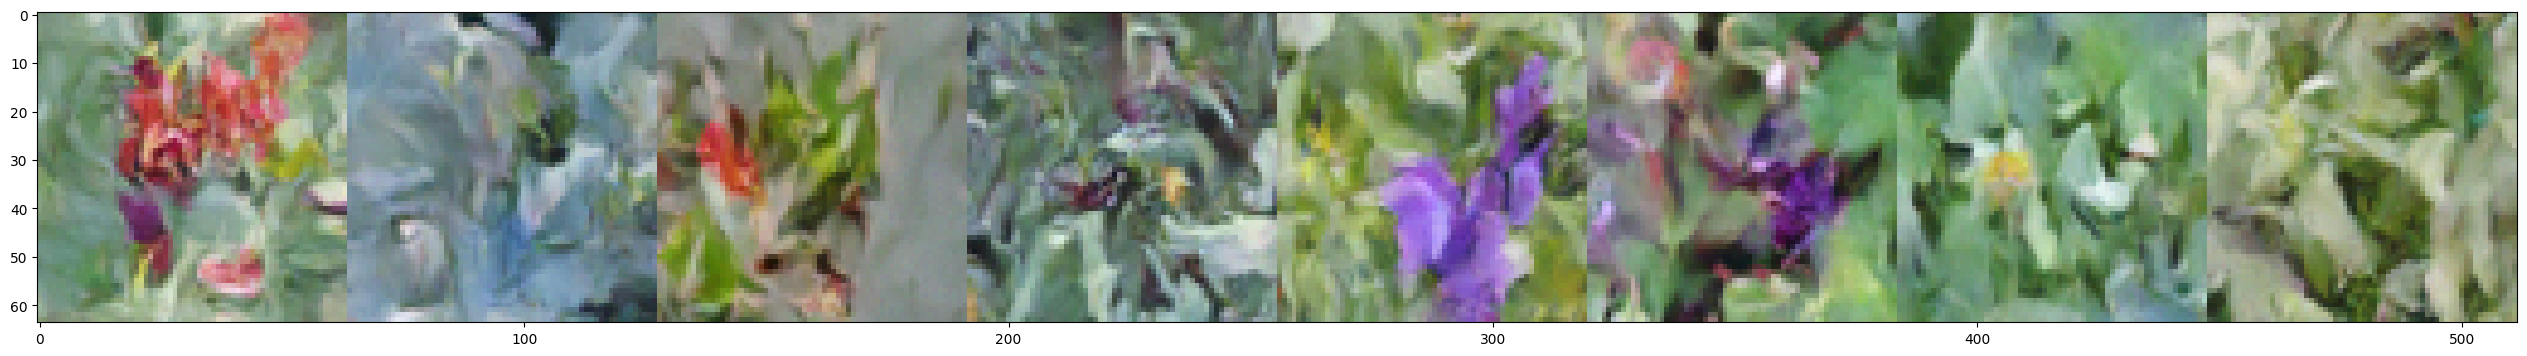

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0678]
299it [00:30,  9.80it/s]


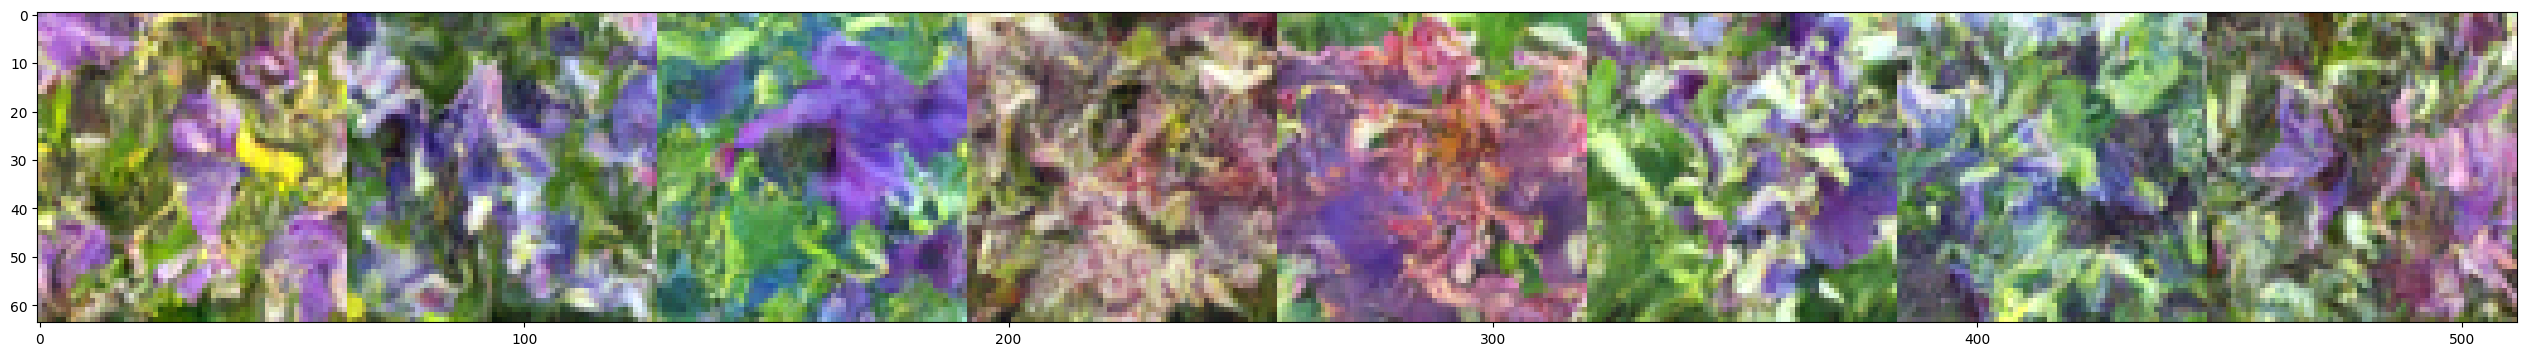

100%|██████████| 896/896 [04:57<00:00,  3.02it/s, MSE=0.067]
299it [00:30,  9.79it/s]


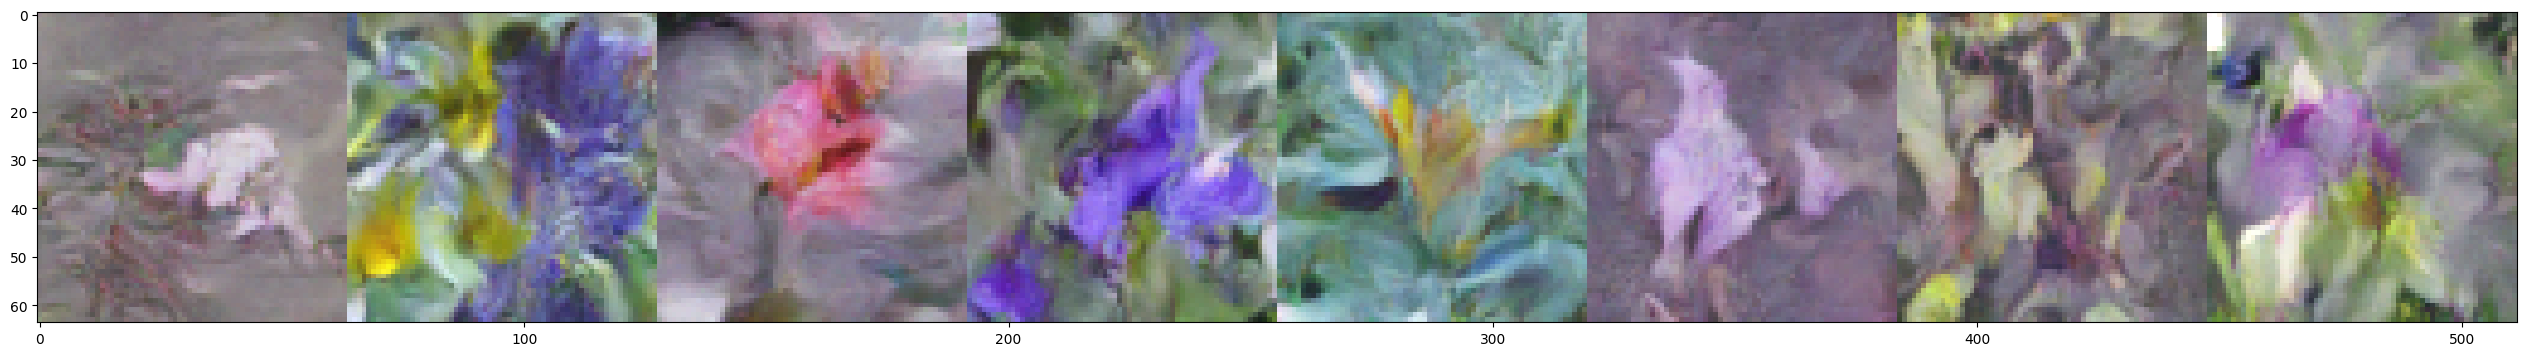

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0445]
299it [00:30,  9.80it/s]


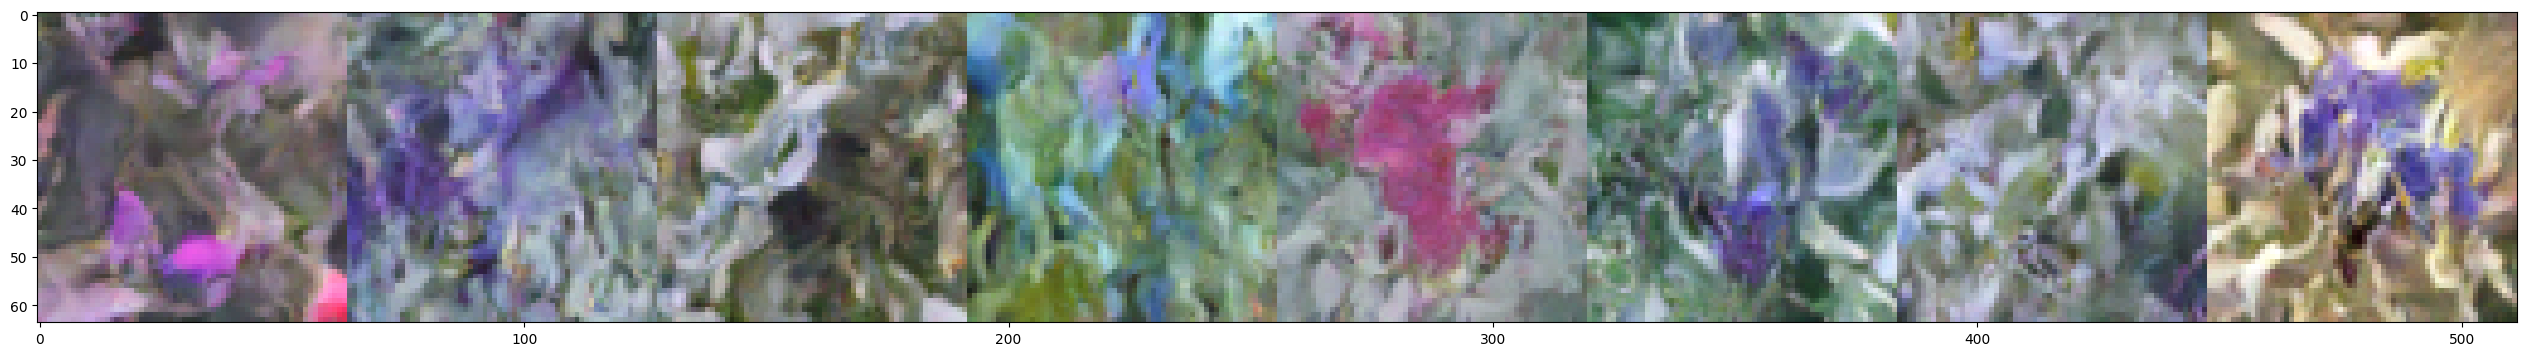

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0805]
299it [00:30,  9.79it/s]


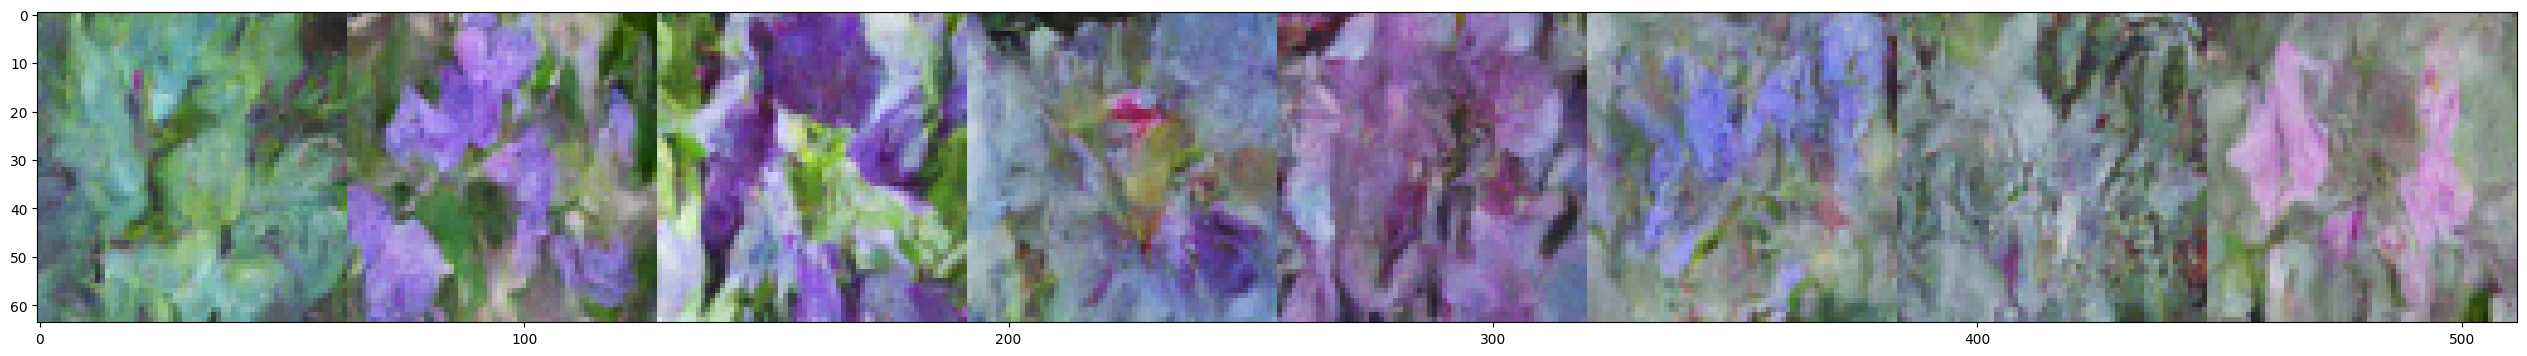

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0494]
299it [00:30,  9.78it/s]


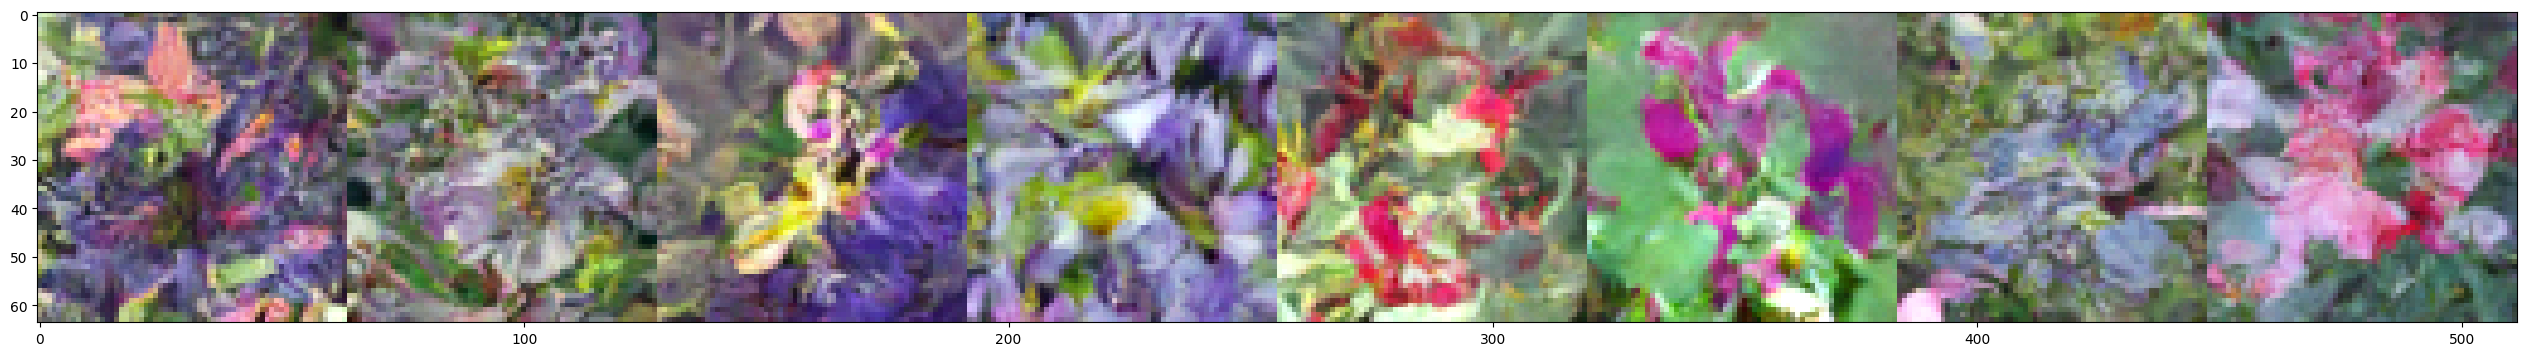

100%|██████████| 896/896 [04:57<00:00,  3.01it/s, MSE=0.036]
299it [00:30,  9.78it/s]


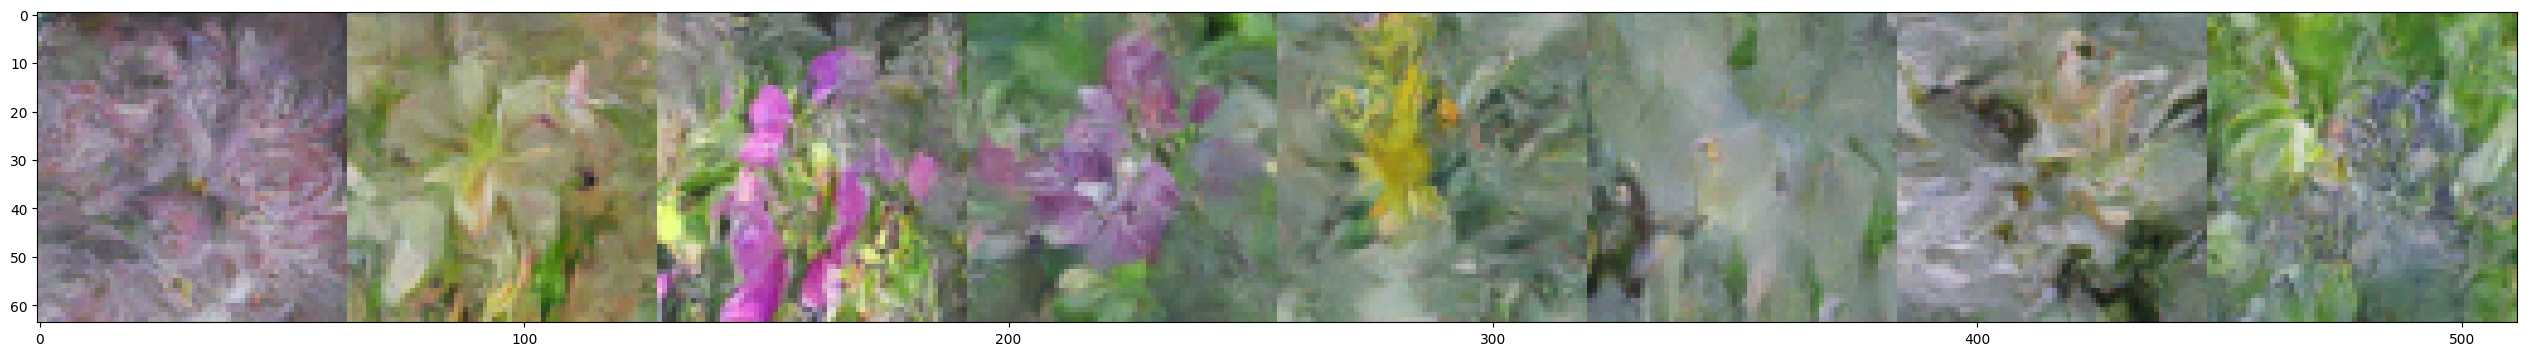

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0262]
299it [00:30,  9.79it/s]


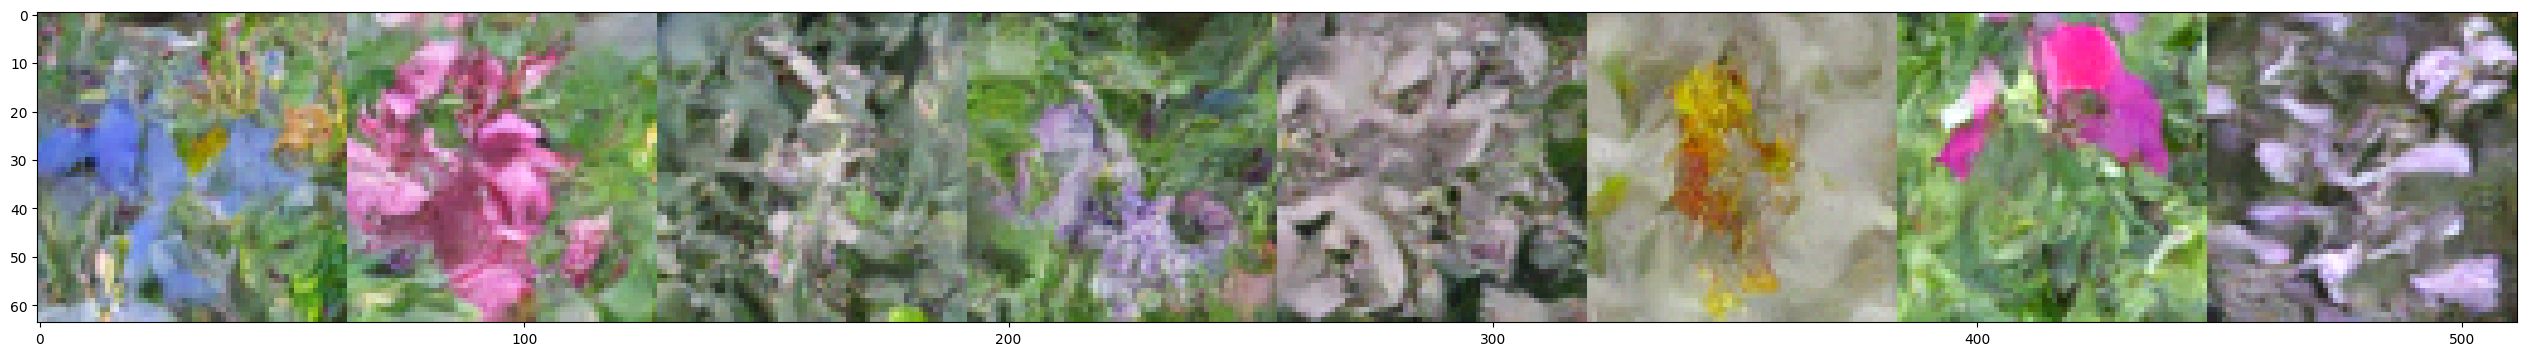

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0516]
299it [00:30,  9.79it/s]


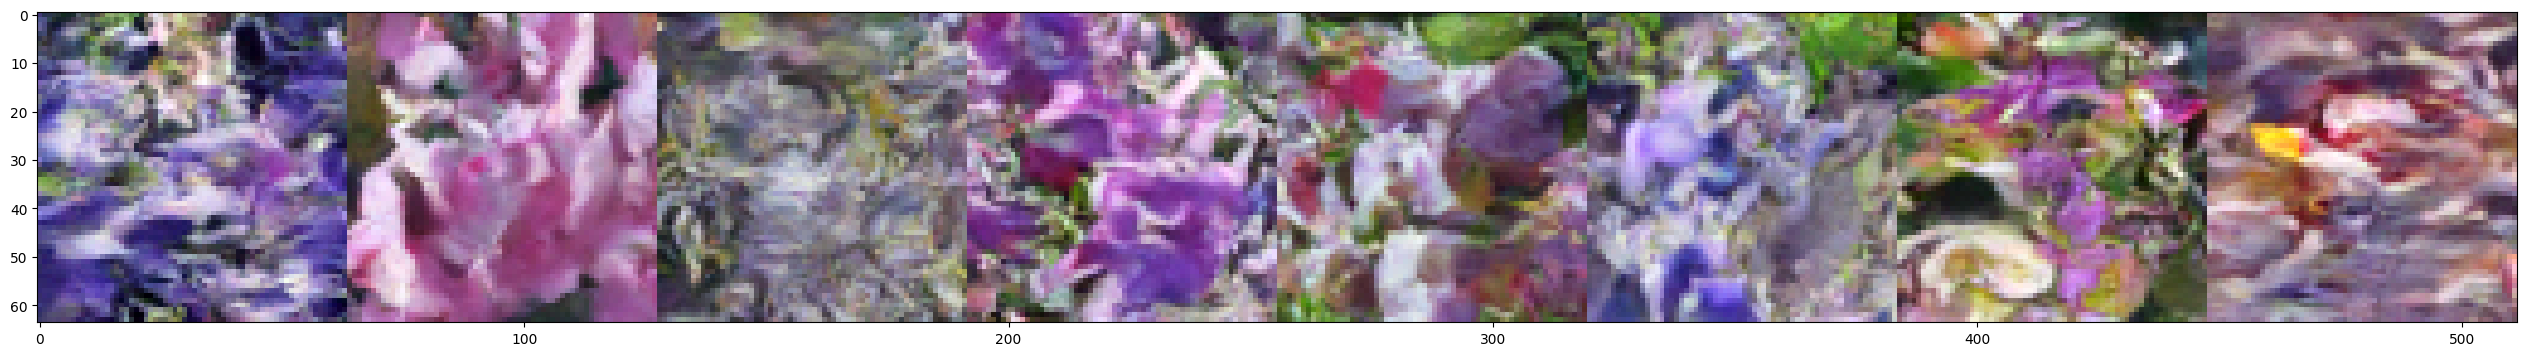

100%|██████████| 896/896 [04:56<00:00,  3.02it/s, MSE=0.0601]
299it [00:30,  9.79it/s]


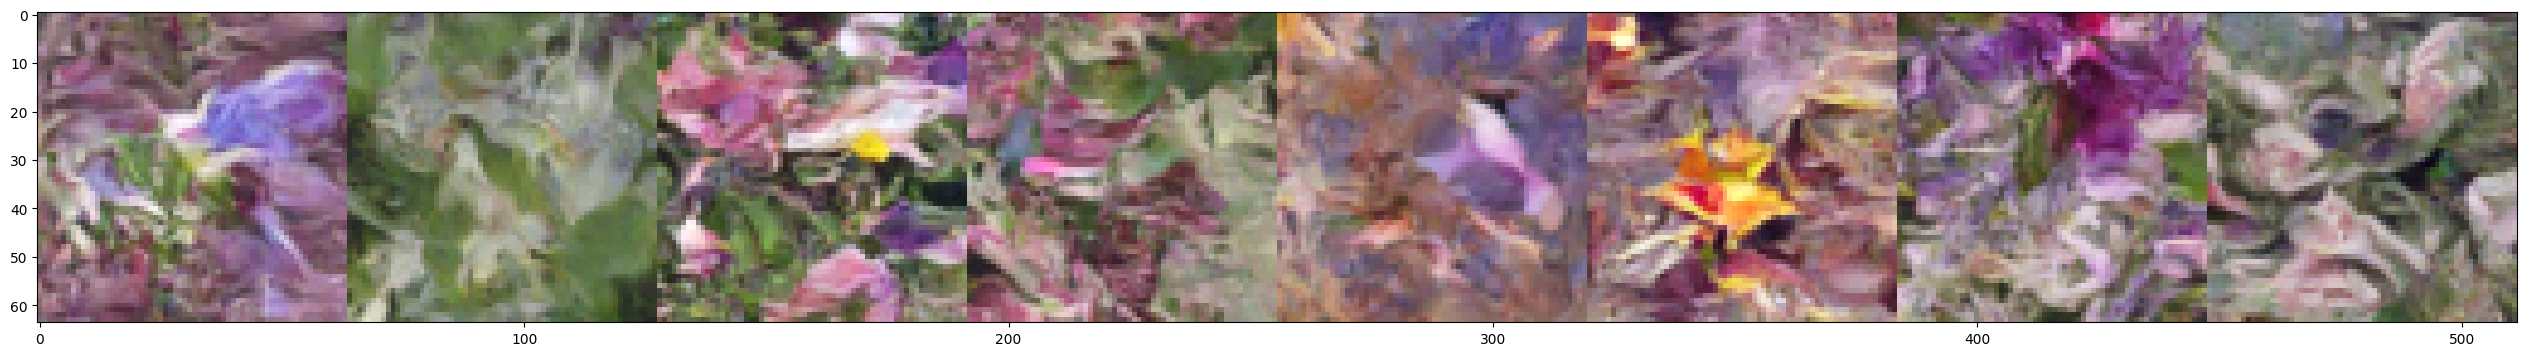

In [18]:
import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()
args.run_name = "DDPM"
args.epochs = 30
args.device = "cuda"
args.lr = 3e-4
train(dataloader, args)